In [1]:
# from pycaret.time_series import *

import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import category_encoders as ce

# Visualization
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
import matplotlib
import seaborn as sns
import plotly.express as px
%matplotlib inline
matplotlib.rcParams['font.family'] = 'Malgun Gothic' # 한글 패치
# Preprocessing & Feature Engineering
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import SelectPercentile

# Hyperparameter Optimization
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Modeling
# from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.neural_network import MLPClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import ExtraTreesClassifier
# from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier, XGBRegressor, XGBRFRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier, VotingRegressor 
from sklearn.ensemble import StackingClassifier, StackingRegressor
# from sklearn.base import ClassifierMixin

# CatBoost
from catboost import CatBoostRegressor

# PyTorch
# import torch
# from torch.utils.data import Dataset, DataLoader, TensorDataset
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim
# from torch.autograd import Variable
# from torch.nn import Parameter
# from torch import Tensor
# from torch.utils.data import DataLoader

# Evaluation
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss,mean_squared_error

# Utility
import os
import time
import datetime # ⚠️2019년 12월30일과 31일의 week of year가 1인 오류가 있음
import random
import warnings; warnings.filterwarnings("ignore")
from IPython.display import Image
import pickle
from tqdm import tqdm
import platform
from itertools import combinations
from scipy.stats.mstats import gmean
import holidays

# from bayes_opt import BayesianOptimization
# from num2words import num2words
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import OLSInfluence

In [2]:
# 모든 컬럼을 표시하도록 설정
pd.set_option('display.max_columns', None)

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(2023)

import warnings
warnings.filterwarnings('ignore')

In [3]:
path = '../data/daegu/'
train_org = pd.read_csv(path+'train.csv')
test_org = pd.read_csv(path+'test.csv')
submit = pd.read_csv(path+'sample_submission.csv')

In [4]:
train_org.columns

Index(['ID', '사고일시', '요일', '기상상태', '시군구', '도로형태', '노면상태', '사고유형',
       '사고유형 - 세부분류', '법규위반', '가해운전자 차종', '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도',
       '피해운전자 차종', '피해운전자 성별', '피해운전자 연령', '피해운전자 상해정도', '사망자수', '중상자수',
       '경상자수', '부상자수', 'ECLO'],
      dtype='object')

In [5]:
test_org.columns

Index(['ID', '사고일시', '요일', '기상상태', '시군구', '도로형태', '노면상태', '사고유형'], dtype='object')

In [6]:
train_org[train_org['사고일시']=='2019-01-04 07']

,ID,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형,사고유형 - 세부분류,법규위반,가해운전자 차종,가해운전자 성별,가해운전자 연령,가해운전자 상해정도,피해운전자 차종,피해운전자 성별,피해운전자 연령,피해운전자 상해정도,사망자수,중상자수,경상자수,부상자수,ECLO
95,ACCIDENT_00095,2019-01-04 07,금요일,맑음,대구광역시 달서구 이곡동,단일로 - 기타,건조,차대사람,횡단중,안전운전불이행,화물,남,26세,상해없음,보행자,여,57세,사망,1,0,0,0,10


### target
 ECLO(Equivalent Casualty Loss Only) : 인명피해 심각도

ECLO = 사망자수 * 10 + 중상자수 * 5 + 경상자수 * 3 + 부상자수 * 1
본 대회에서는 사고의 위험도를 인명피해 심각도로 측정

#### 파생변수 추가 ↓↓↓

In [7]:
# Baseline code 2
### train, test의 시간정보와 공간정보를 분류하고
### 공간정보를 기준으로 위에서 만든 데이터셋과 merge

train_df = train_org.copy()
test_df = test_org.copy()

time_pattern = r'(\d{4})-(\d{1,2})-(\d{1,2}) (\d{1,2})'

train_df[['연', '월', '일', '시간']] = train_org['사고일시'].str.extract(time_pattern)
train_df[['연', '월', '일', '시간']] = train_df[['연', '월', '일', '시간']].apply(pd.to_numeric) # 추출된 문자열을 수치화해줍니다
# train_df = train_df.drop(columns=['사고일시']) # 정보 추출이 완료된 '사고일시' 컬럼은 제거합니다

# 해당 과정을 test_x에 대해서도 반복해줍니다
test_df[['연', '월', '일', '시간']] = test_org['사고일시'].str.extract(time_pattern)
test_df[['연', '월', '일', '시간']] = test_df[['연', '월', '일', '시간']].apply(pd.to_numeric)
# test_df = test_df.drop(columns=['사고일시'])

train_df['사고일시'] = pd.to_datetime(train_df['사고일시'])
test_df['사고일시'] = pd.to_datetime(test_df['사고일시'])

##################################### 🔻피처 추가
import holidays
def make_holi(x):
    kr_holi = holidays.KR()
    if x in kr_holi:
        # 공휴일vs비공휴일 eclo가 큰 차이를 보이지 않기 때문에 0.5만
        return 0.5
    else:
        return 0

for df in [train_df,test_df]:
    # 제주감귤 공휴일 추출 코드 참고
    # 공휴일 변수 추가
    df["공휴일"] = df["사고일시"].map(lambda x : make_holi(x))

    # 주말 컬럼 추가
    # 주말vs평일 eclo가 큰 차이를 보이지 않기 때문에 0.5만
    df['주말'] = df['요일'].map(lambda x:0.5 if x in ['토요일','일요일'] else 0)
    
    # 연평균 eclo의 감소 추세 반영
    # 일단 대충 넣어두기
    years = dict(zip([2019,2020,2021,2022,2023],[5,4,3,2,1]))
    df['연평균추세']=df['연'].map(lambda x:years.get(x))
    
    # 시야감소 컬럼 추가 (시간이 20시~04시 사이인 경우)
    # 이 시간대와 이 시간대 외의 eclo가 0.5~1.4 차이가 나므로 1값을 준다.
    df['시야지수'] = df['시간'].map(lambda x:1 if (x>=20)|(x<=4) else 0)

    # 과속가능성
    # 일단 도로형태로 처리
#     fast_doro = ['단일로 - 기타','교차로 - 교차로부근','교차로 - 교차로안']
#     df['과속가능성'] = df['도로형태'].map(lambda x:1 if x in fast_doro else 0)
    
    


################################################# 🔻외부 데이터
location_pattern = r'(\S+) (\S+) (\S+)'

train_df[['도시', '구', '동']] = train_org['시군구'].str.extract(location_pattern)
# train_df = train_df.drop(columns=['시군구'])

test_df[['도시', '구', '동']] = test_org['시군구'].str.extract(location_pattern)
# test_df = test_df.drop(columns=['시군구'])

# 도로형태 나누지 말자.
# road_pattern = r'(.+) - (.+)'

# train_df[['도로형태1', '도로형태2']] = train_org['도로형태'].str.extract(road_pattern)
# train_df = train_df.drop(columns=['도로형태'])

# test_df[['도로형태1', '도로형태2']] = test_org['도로형태'].str.extract(road_pattern)
# test_df = test_df.drop(columns=['도로형태'])

# Baseline code 1
### 보안등, 어린이 보호구역, 주차장 정보를 주소 기준으로 분류
light_df = pd.read_csv(path+'external_open/대구 보안등 정보.csv', encoding='cp949')[['설치개수', '소재지지번주소']]
location_pattern = r'(\S+) (\S+) (\S+) (\S+)'
light_df[['도시', '구', '동', '번지']] = light_df['소재지지번주소'].str.extract(location_pattern)
light_df = light_df.drop(columns=['소재지지번주소', '번지'])
light_df = light_df.groupby(['도시', '구', '동']).sum().reset_index()
light_df.reset_index(inplace=True, drop=True)
light_df = light_df.rename({'설치개수':'보안등개수'})
train_df = pd.merge(train_df, light_df, how='left', on=['도시', '구', '동'])
test_df = pd.merge(test_df, light_df, how='left', on=['도시', '구', '동'])

child_area_df = pd.read_csv(path+'external_open/대구 어린이 보호 구역 정보.csv', encoding='cp949').drop_duplicates()[['소재지지번주소']]
child_area_df['cnt'] = 1
location_pattern = r'(\S+) (\S+) (\S+) (\S+)'
child_area_df[['도시', '구', '동', '번지']] = child_area_df['소재지지번주소'].str.extract(location_pattern)
child_area_df = child_area_df.drop(columns=['소재지지번주소', '번지'])
child_area_df = child_area_df.groupby(['도시', '구', '동']).sum().reset_index()
child_area_df.reset_index(inplace=True, drop=True)
train_df = pd.merge(train_df, child_area_df, how='left', on=['도시', '구', '동'])
test_df = pd.merge(test_df, child_area_df, how='left', on=['도시', '구', '동'])
### ??? 주차장 정보가 필요할까? 
# 가설 : 주차장이 많을수록 도로변 "불법주정차" 수가 줄어 
# 시야 확보에 도움이 될 수 있다. -> ECLO가 낮을 것 <<기각...>>
parking_df = pd.read_csv(path+'external_open/대구 주차장 정보.csv', encoding='cp949')[['소재지지번주소', '급지구분']]
parking_df = pd.get_dummies(parking_df, columns=['급지구분'])
location_pattern = r'(\S+) (\S+) (\S+) (\S+)'
parking_df[['도시', '구', '동', '번지']] = parking_df['소재지지번주소'].str.extract(location_pattern)
parking_df = parking_df.drop(columns=['소재지지번주소', '번지'])
parking_df = parking_df.groupby(['도시', '구', '동']).sum().reset_index()
parking_df.reset_index(inplace=True, drop=True)
train_df = pd.merge(train_df, parking_df, how='left', on=['도시', '구', '동'])
test_df = pd.merge(test_df, parking_df, how='left', on=['도시', '구', '동'])

In [8]:
parking = pd.read_csv(path+'external_open/대구 주차장 정보.csv', encoding='cp949')
parking.columns

Index(['주차장관리번호', '주차장명', '주차장구분', '주차장유형', '소재지도로명주소', '소재지지번주소', '주차구획수',
       '급지구분', '부제시행구분', '운영요일', '평일운영시작시각', '평일운영종료시각', '토요일운영시작시각',
       '토요일운영종료시각', '공휴일운영시작시각', '공휴일운영종료시각', '요금정보', '주차기본시간', '주차기본요금',
       '추가단위시간', '추가단위요금', '1일주차권요금적용시간', '1일주차권요금', '월정기권요금', '결제방법', '특기사항',
       '위도', '경도', '데이터기준일자'],
      dtype='object')

In [9]:
train_df.columns

Index(['ID', '사고일시', '요일', '기상상태', '시군구', '도로형태', '노면상태', '사고유형',
       '사고유형 - 세부분류', '법규위반', '가해운전자 차종', '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도',
       '피해운전자 차종', '피해운전자 성별', '피해운전자 연령', '피해운전자 상해정도', '사망자수', '중상자수',
       '경상자수', '부상자수', 'ECLO', '연', '월', '일', '시간', '공휴일', '주말', '연평균추세',
       '시야지수', '도시', '구', '동', '설치개수', 'cnt', '급지구분_1', '급지구분_2', '급지구분_3'],
      dtype='object')

# EDA

### 1. 날짜별 EDA

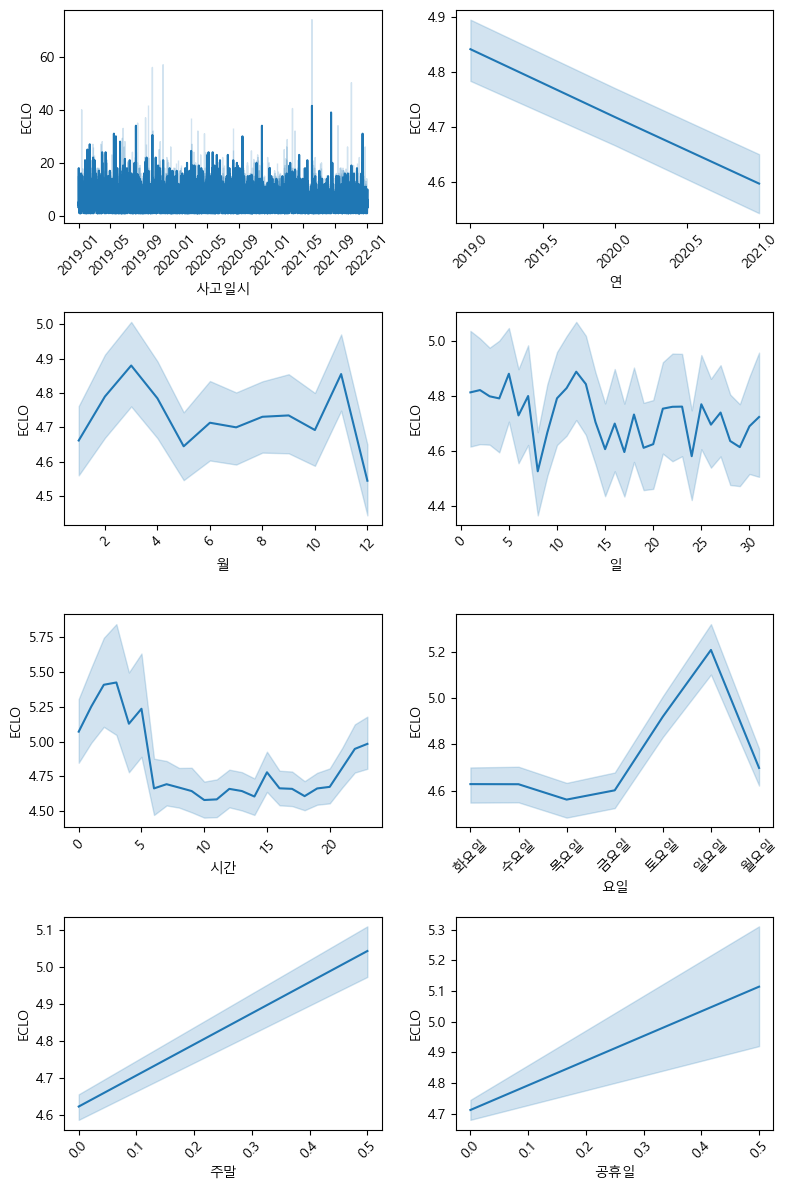

In [10]:
# 시간대별 ECLO 확인
i = 0 
columns=['사고일시','연','월','일','시간','요일','주말','공휴일']
sub_cols = 2
sub_rows = (len(columns)+1) // 2
width = len(columns)
height = sub_rows * 3

plt.figure(figsize=(width, height)) # figure의 width height는 맘대로
for col in columns:
    i += 1
    plt.subplot(sub_rows,sub_cols,i)
    sns.lineplot(data=train_df,x=col, y='ECLO', errorbar='ci')
    plt.xticks(rotation=45)
plt.tight_layout()

### 2. 도로형태 - 단일로/교차로/지하차도/주차장/횡단보도/기타/..

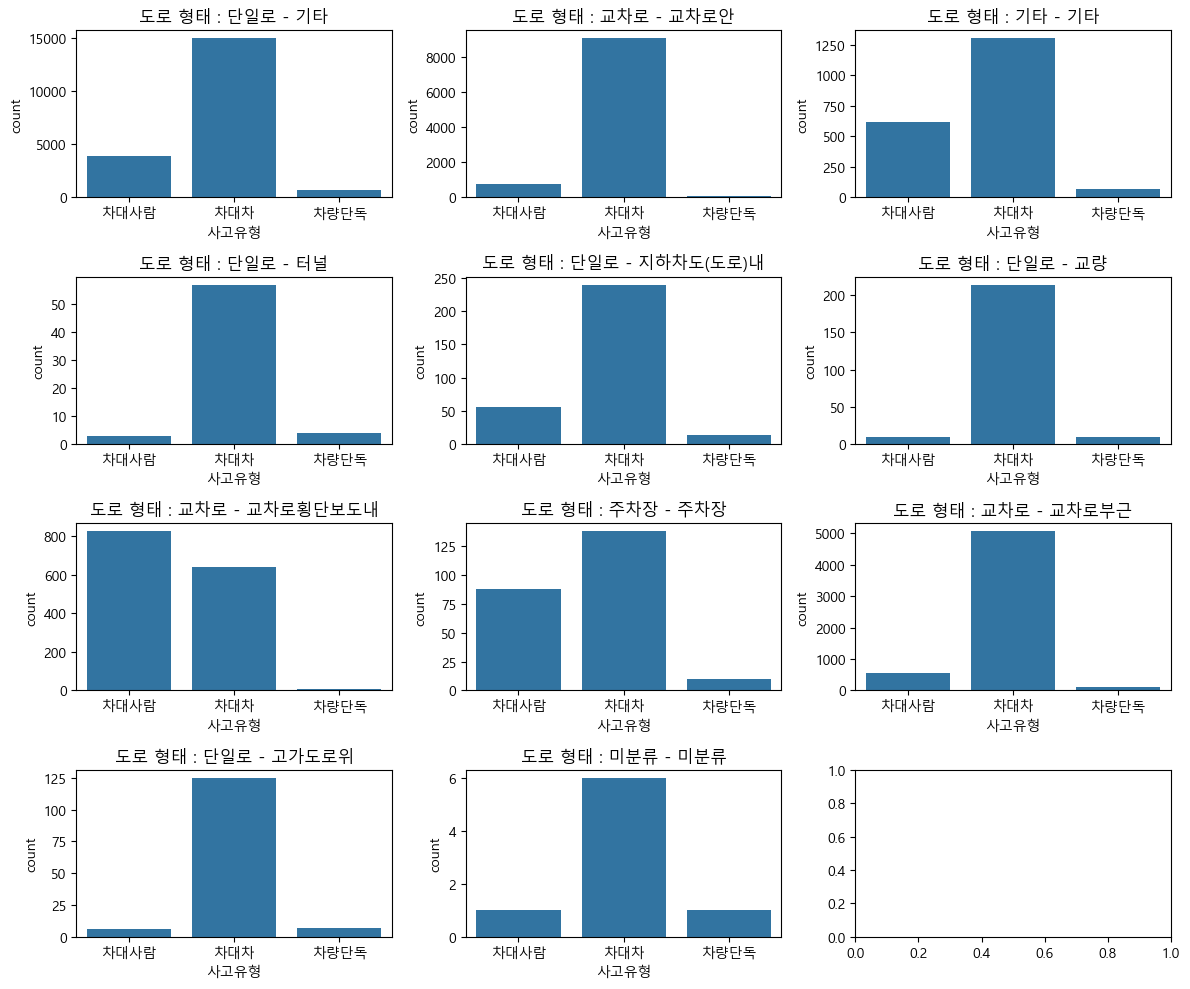

In [11]:
fig, axes = plt.subplots(4,3, figsize=(12,10))

# x축 label 순서 맞추기
x_order = train_org['사고유형'].unique()

for (ax, k) in zip(axes.flatten(), train_org['도로형태'].unique()):
    sns.countplot(x='사고유형', data=train_org[train_org['도로형태'] == k], ax=ax, order=x_order)
    ax.set_title(f"도로 형태 : {k}")

plt.tight_layout()
plt.show()

### 지도 시각화

In [12]:
import folium
from geopy.geocoders import Nominatim
import time
def get_coordinates(address):
    geolocator = Nominatim(user_agent = "South Korea")
    location = geolocator.geocode(address)

    if location:
        return location.latitude, location.longitude
    else:
        return 0
locations = [{address:get_coordinates(address)} for address in train_org['시군구'].unique()]
import json
# with open('../data/daegu/geo.json', "w", encoding='utf-8') as f:
#     json.dump(locations, f, ensure_ascii=False,indent=2)

with open('../data/daegu/geo.json', 'r', encoding='utf-8') as f:
    locations = json.load(f)
    

GeocoderUnavailable: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=%EB%8C%80%EA%B5%AC%EA%B4%91%EC%97%AD%EC%8B%9C+%EB%8F%99%EA%B5%AC+%EC%8B%A0%EA%B8%B0%EB%8F%99&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))

In [ ]:
##  중복된 좌표 있는지 확인
coordinates_set = set()

duplicates = []
nan_coordinates = []
for loc in locations:
    try:
        coordinates = tuple(list(loc.values())[0])
    except:
        coordinates = None
    if coordinates in coordinates_set:
        duplicates.append(loc)

    elif coordinates == (0,0):
        nan_coordinates.append(loc)
    else:
        coordinates_set.add(coordinates)

if duplicates:
    print("중복된 데이터가 있습니다:")
    for duplicate in duplicates:
        print(duplicate)
else:
    print("중복된 데이터가 없습니다.")

locations_dict = {key: value for item in locations for key, value in item.items()}
# 달서구 대곡동 좌표 입력(구글 검색해서)
locations_dict['대구광역시 달서구 대곡동'] = (35.7987376,128.5277021)
## 발생횟수 정규화
count_df = train_org.groupby(by='시군구').count()['ID'].reset_index()
count_df
def normalize_column(column):
    min_value = column.min()
    max_value = column.max()
    normalized_column = (column - min_value) / (max_value - min_value)
    return normalized_column

count_df['count'] = normalize_column(count_df['ID'])
count_df

# 발생횟수 시각화
map_daegu = folium.Map(location=[35.8714, 128.6014], zoom_start=12)

for i in range(len(count_df)):
    r = count_df.iloc[i]['count']*50
    name = count_df.iloc[i]['시군구'].split(' ')[-2]+count_df.iloc[i]['시군구'].split(' ')[-1]
    folium.CircleMarker(locations_dict[count_df.iloc[i]['시군구']],
                        popup=f'{name}',
                        radius=r, color='purple',fill_color='plum',
                        fill=True).add_to(map_daegu)

map_daegu

In [ ]:
# ECLO 시각화

## 시 군구별 ECLO 평균

mean_df = train_org.groupby(by='시군구')['ECLO'].mean().reset_index()

map_daegu = folium.Map(location=[35.8714, 128.6014], zoom_start=12)

for i in range(len(mean_df)):
    r = mean_df.iloc[i]['ECLO']*3
    name = mean_df.iloc[i]['시군구'].split(' ')[-2]+mean_df.iloc[i]['시군구'].split(' ')[-1]
    folium.CircleMarker(locations_dict[mean_df.iloc[i]['시군구']],
                        popup=f'{name}',
                        radius=r, color='purple',fill_color='plum',
                        fill=True).add_to(map_daegu)

map_daegu

### 주차장과 ECLO 관계
- 가설 : 주차장이 많은 시군구일수록 ECLO가 낮을 것
> 가설 기각. 주차장이랑 별 관계 없는 듯.

### 기타 시각화

In [ ]:
### 이상치 탐색
i = 0 
columns = ['요일',
 '기상상태',
#  '시군구',
 '도로형태',
 '노면상태',
 '사고유형',
 '사고유형 - 세부분류',
 '법규위반',
 '가해운전자 차종',
 '가해운전자 성별',
 '가해운전자 상해정도',
 '피해운전자 차종',
 '피해운전자 성별',
 '피해운전자 상해정도',
 '공휴일',
  '주말']
sub_cols = 2
sub_rows = (len(columns)+1) // 2

plt.figure(figsize=(len(columns), sub_rows*4)) # figure의 width height는 맘대로
for col in columns:
    i += 1
    plt.subplot(sub_rows,sub_cols,i)
    sns.boxplot(x=train_df[col], y=train_df['ECLO'])
    plt.xticks(rotation=45)
plt.tight_layout()

In [ ]:
i = 0 
columns = ['요일',
 '기상상태',
 '시군구',
 '도로형태',
 '노면상태',
 '사고유형',
 '사고유형 - 세부분류',
 '법규위반',
 '가해운전자 차종',
 '가해운전자 성별',
 '가해운전자 상해정도',
 '피해운전자 차종',
 '피해운전자 성별',
 '피해운전자 상해정도',
 '공휴일',
  '주말']
sub_cols = 2
sub_rows = (len(columns)+1) // 2

plt.figure(figsize=(len(columns), sub_rows*4)) # figure의 width height는 맘대로
for col in columns:
    i += 1
    plt.subplot(sub_rows,sub_cols,i)
    sns.barplot(x=train_df[col], y=train_df['ECLO'],ci=None)
    plt.xticks(rotation=45)
plt.tight_layout()

In [ ]:
sns.displot(data=train_df, x='ECLO', hue='공휴일',kind='kde')
plt.show()
sns.displot(data=train_df, x='ECLO',hue = '주말',kind='kde')
plt.show()

---

In [ ]:
train_df.groupby('사고유형')['사고유형 - 세부분류'].unique()

In [ ]:
sns.lineplot(data=train_df,x='사고유형 - 세부분류',y='ECLO')#,hue='사고유형 - 세부분류')
xax = train_df['사고유형 - 세부분류'].unique()
number = train_df['사고유형 - 세부분류'].nunique()
sns.lineplot(x=xax, y=[5 for _ in range(number)])
sns.lineplot(x=xax, y=[3.5 for _ in range(number)])
plt.xticks(rotation=90)
plt.grid()
plt.show()

In [ ]:
import pandas as pd
import scipy.stats as stats
import numpy as np

def cramer_V(data):
    '''
    - data : 2개의 컬럼으로 이루어진 데이터프레임객체
    - return : (V계수, p_value)
    '''
    len1,len2 = data.iloc[:,0].nunique(),data.iloc[:,1].nunique()
    q = min([len1,len2])
    data['dummy'] = 0 # pivot table을 만들기 위한 더미값
    pivot = pd.pivot_table(data,
        index=data.columns[0],
        columns=data.columns[1],
        values='dummy',
        aggfunc='count'
        ) # 도수분포표 생성
    pivot = pivot.fillna(0)
    
    n = pivot.sum().sum()
    
    chi_obj = stats.chi2_contingency(pivot,correction=False)
    X2 = chi_obj.statistic # 카이제곱값 구하기
    p_value = chi_obj.pvalue

    V = np.sqrt(X2 / (n*(q-1))) # V 계수

    return (V,p_value)

In [ ]:
i = 0 
for col in ['요일',
 '기상상태',
 '시군구',
 '도로형태',
 '노면상태',
 '사고유형',
 '사고유형 - 세부분류',
#  '법규위반',
 '가해운전자 차종',
 '가해운전자 성별',
 '가해운전자 상해정도',
 '피해운전자 차종',
 '피해운전자 성별',
 '피해운전자 상해정도']:
    subset = train_df[[col,'법규위반']]
    v,pvalue = cramer_V(subset)
    print('{} V={:.5f}, pvalue={:.4f}'.format(col,v,pvalue))

In [ ]:
from itertools import combinations

cols = ['요일',
 '기상상태',
 '시군구',
 '도로형태',
 '노면상태',
 '사고유형',
 '사고유형 - 세부분류',
 '법규위반',
 '가해운전자 차종',
 '가해운전자 성별',
 '가해운전자 상해정도',
 '피해운전자 차종',
 '피해운전자 성별',
 '피해운전자 상해정도']

combi_list = list(combinations(cols,2))

v_threshold_1 = 0.5
v_threshold_1s = []
v_threshold_2 = 0.2
v_threshold_2s = []

for feature,target in combi_list:
    subset = train_df[[feature,target]]
    v,p = cramer_V(subset)
    if v >= 0.5 and p<=0.05:
        v_threshold_1s.append((feature,target,np.round(v,4)))
    elif v>=0.2 and p<=0.05:
        v_threshold_2s.append((feature,target,np.round(v,4)))
    else:
        continue

print('0.5 이상')
print(v_threshold_1s)
print()
print('0.2 이상')
print(v_threshold_2s)


In [ ]:
from itertools import combinations

cols = ['요일',
 '기상상태',
 '시군구',
 '도로형태',
 '노면상태',
 '사고유형',
 '사고유형 - 세부분류',
 '법규위반',
 '가해운전자 차종',
 '가해운전자 성별',
 '가해운전자 상해정도',
 '피해운전자 차종',
 '피해운전자 성별',
 '피해운전자 상해정도']

for combi in range(6,15):
    combi_list = list(combinations(cols,combi))

    v_threshold_1 = 0.5
    v_threshold_1s = []
    v_threshold_2 = 0.2
    v_threshold_2s = []

    for combis in combi_list:
#         print(list(combis))
        subset = train_df[list(combis)]
        v,p = cramer_V(subset)
        if v >= 0.5 and p<=0.05:
            v_threshold_1s.append((combis,np.round(v,4)))
        elif combi >= 10 and v>=0.2 and p<=0.05:
            v_threshold_2s.append((combis,np.round(v,4)))
        else:
            continue
    print(f'--------- 조합: {combi} ---------')
    print('0.5 이상')
    print(v_threshold_1s)
    print()
    if combi >= 10:
        print('0.2 이상')
        print(v_threshold_2s)


In [ ]:
i = 0 
plt.figure(figsize=(14,26))
for col in ['요일',
 '기상상태',
 '시군구',
 '도로형태',
 '노면상태',
 '사고유형',
 '사고유형 - 세부분류',
 '법규위반',
 '가해운전자 차종',
 '가해운전자 성별',
 '가해운전자 상해정도',
 '피해운전자 차종',
 '피해운전자 성별',
 '피해운전자 상해정도']:
    i += 1
    plt.subplot(7,2,i)
    sns.barplot(x=train_df[col], y=train_df['ECLO'],ci=None)
    plt.xticks(rotation=45)
plt.tight_layout()

In [ ]:
thresholds = v_threshold_1s+v_threshold_2s

i = 0 

sub_cols = 2
sub_rows = (len(thresholds)+1) // 2

plt.figure(figsize=(14, 26))
for col1,col2,_ in thresholds:
    i += 1
    if train_df[col1].nunique() < train_df[col2].nunique():
        col1, col2 = col2, col1
    plt.subplot(sub_rows,sub_cols,i)
    sns.countplot(data=train_df,x=col1, hue=col2)
    plt.xticks(rotation=45)
plt.tight_layout()


In [ ]:
train_df.columns

In [ ]:
# 로지스티 회귀분석으로 범주형 데이터와 taget 연관성 분석
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
features = ['기상상태', '시군구', '도로형태', '노면상태',
    '사고유형','사고유형 - 세부분류', '법규위반', '가해운전자 차종',
    '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도',
    '피해운전자 차종', '피해운전자 성별', '피해운전자 연령', 
    '피해운전자 상해정도', '연','월','일','시간','요일']
categorical_features = list(train_df[features].dtypes[train_df[features].dtypes == "object"].index)

train_df_le = train_df[features].copy()
for i in categorical_features:
    le = LabelEncoder()
    train_df_le[i] = le.fit_transform(train_df_le[i])

### one-hot
dum = pd.get_dummies(train_df[categorical_features],dtype=int)
X_ = pd.concat([dum,train_df[['연','월','일','시간']]],axis=1)

X = train_df_le
y = train_df['ECLO']


lgr = LogisticRegression(solver='saga',penalty='elasticnet',l1_ratio=0.7)
result = lgr.fit(X,y)

lgr_one_hot = LogisticRegression(solver='saga',penalty='elasticnet',l1_ratio=0.7)
result_ = lgr_one_hot.fit(X_,y)

In [ ]:
### LabelEncoding ###
coef_one_hot = pd.DataFrame(np.abs(lgr_one_hot.coef_)*100,columns=X_.columns)
sorted_columns = coef_one_hot.mean().sort_values(ascending=False).index
# DataFrame의 컬럼을 정렬된 순서로 변경
coef_one_hot = coef_one_hot[sorted_columns]
# 출력 형식을 지수 표기법에서 십진수로 변경
pd.set_option('display.float_format', '{:.10f}'.format)
coef_one_hot.describe()

In [ ]:
### LabelEncoding ###
coef = pd.DataFrame(np.abs(lgr.coef_)*100,columns=features)
sorted_columns = coef.mean().sort_values(ascending=False).index
# DataFrame의 컬럼을 정렬된 순서로 변경
coef = coef[sorted_columns]
# 출력 형식을 지수 표기법에서 십진수로 변경
pd.set_option('display.float_format', '{:.10f}'.format)
coef.describe()

## 군집화를 해보자

In [ ]:
train_df.columns

In [ ]:
train_df.isnull().sum()

In [ ]:
from sklearn.cluster import MeanShift,estimate_bandwidth

cluster_X = train_df_.drop(columns=[
    'ID','사고일시','시군구','주말','연평균추세','시야지수',
    '사망자수', '중상자수','경상자수', '부상자수', 'ECLO',
    '피해운전자 차종','피해운전자 성별','피해운전자 연령',
    '피해운전자 상해정도'
])

cluster_X.fillna(0,inplace=True)

categorical = list(cluster_X.dtypes[cluster_X.dtypes == "object"].index)
for c in categorical:
    encoder = LabelEncoder()
    cluster_X[c] = encoder.fit_transform(cluster_X[c])

best_bandwidth = estimate_bandwidth(cluster_X)
print(best_bandwidth)

In [ ]:
ms = MeanShift(bandwidth=best_bandwidth)
labels = ms.fit_predict(cluster_X)
labels